In [1]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Connect to ClickHouse
try:
	client = Client(host='localhost', port=9005, user='default', password='', database='marts')
	# Read the cluster analysis table
	query = 'SELECT * FROM customers_clusters_analysis'
	result = client.execute(query)

	# Convert result to a pandas DataFrame for easier analysis (optional)
	df = pd.DataFrame(result, columns=[desc[0] for desc in client.execute('DESCRIBE TABLE customers_clusters_analysis')])

	display(df.head())
except Exception as e:
	print("Error connecting to ClickHouse:", e)

,cluster,avg_days_since_registration,avg_total_orders,avg_total_spend_usd,avg_avg_order_value_usd,avg_days_since_last_purchase,avg_orders_last_30_days,avg_spend_last_30_days_usd,avg_processing_orders,avg_shipped_orders,...,avg_num_products,avg_total_web_events,avg_unique_pages_visited,avg_days_since_last_web_activity,avg_total_add_to_carts,avg_total_searches,avg_total_page_views,avg_total_product_views,rows_in_cluster,analysis_timestamp
0,0,383.952987,0.0001,0.003434,0.003434,0.204503,0.0001,0.003434,0.0000,0.0000,...,0.0001,0.0296,0.0296,9.698424,0.0030,0.0006,0.0178,0.0059,97661194,2025-09-11 18:00:35
1,0,383.978316,0.0001,0.004830,0.004830,0.146226,0.0001,0.004830,0.0000,0.0000,...,0.0001,0.0313,0.0313,9.097424,0.0031,0.0006,0.0188,0.0062,97477770,2025-09-18 10:22:44
2,1,384.260635,1.0004,450.506214,450.435252,7.544182,1.0004,450.506214,0.1698,0.1697,...,2.8050,0.0620,0.0619,9.317162,0.0062,0.0013,0.0371,0.0124,1241696,2025-09-11 18:00:35
3,1,385.593367,1.0004,460.594795,460.528524,6.801369,1.0004,460.594795,0.1706,0.1706,...,2.8110,0.0688,0.0687,8.384106,0.0069,0.0014,0.0412,0.0137,1370822,2025-09-18 10:22:44
4,2,384.000430,1.0584,1142.630587,1098.376825,9.149186,1.0584,1142.630587,0.2480,0.2473,...,3.4059,0.0628,0.0627,9.548694,0.0063,0.0013,0.0377,0.0126,1097110,2025-09-11 18:00:35


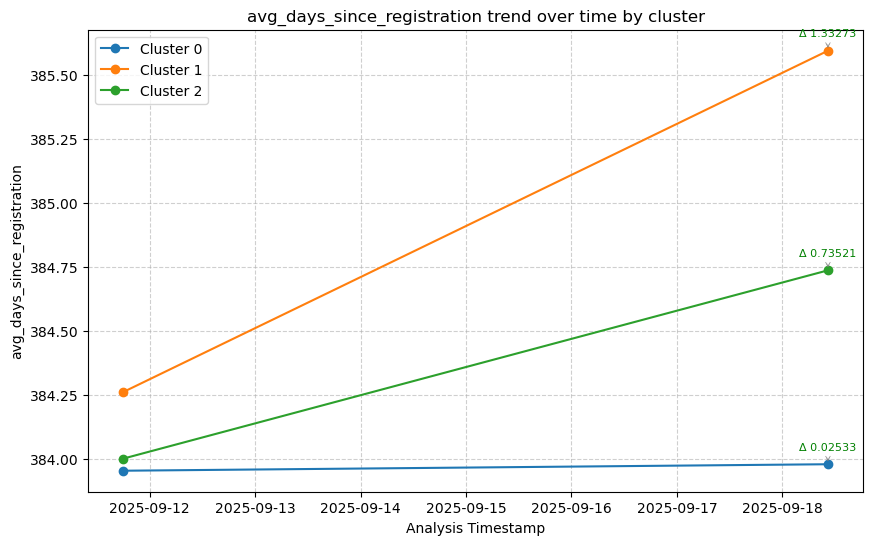

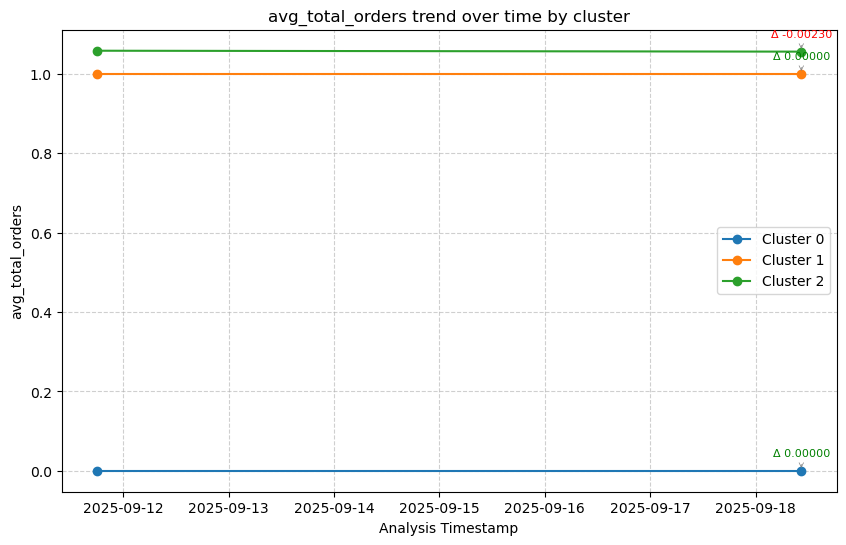

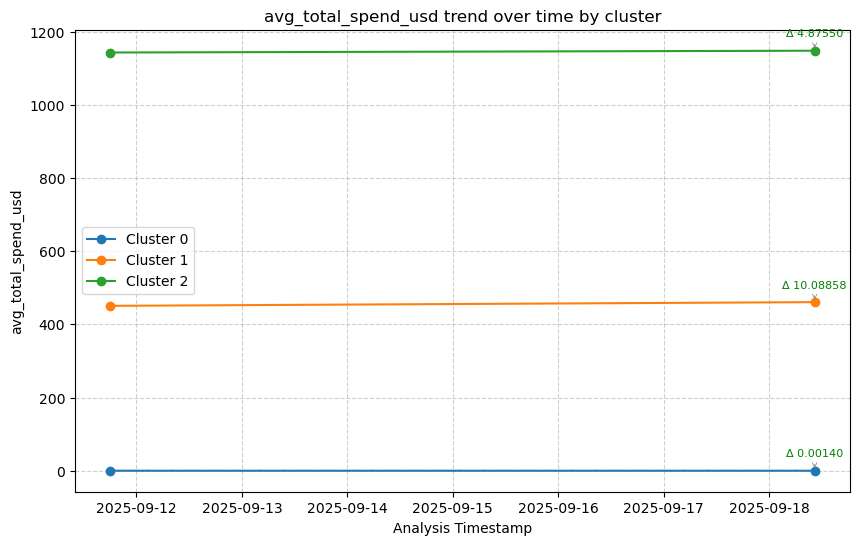

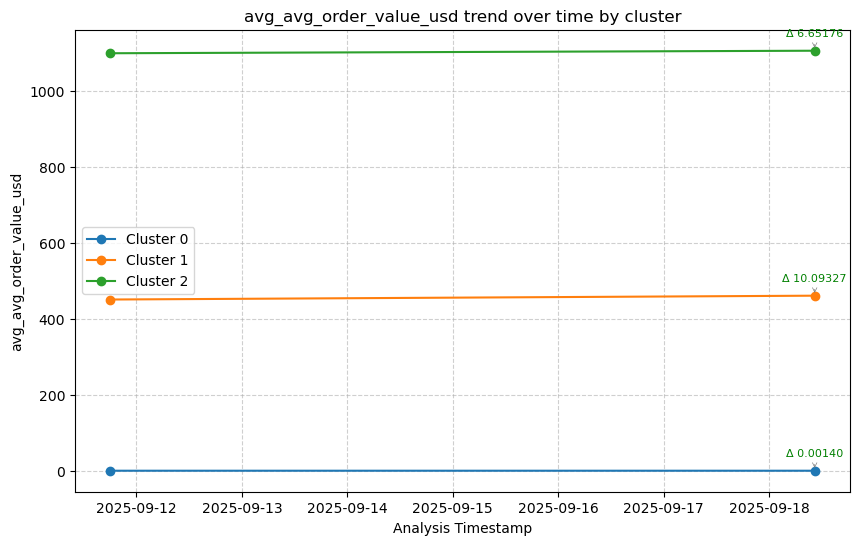

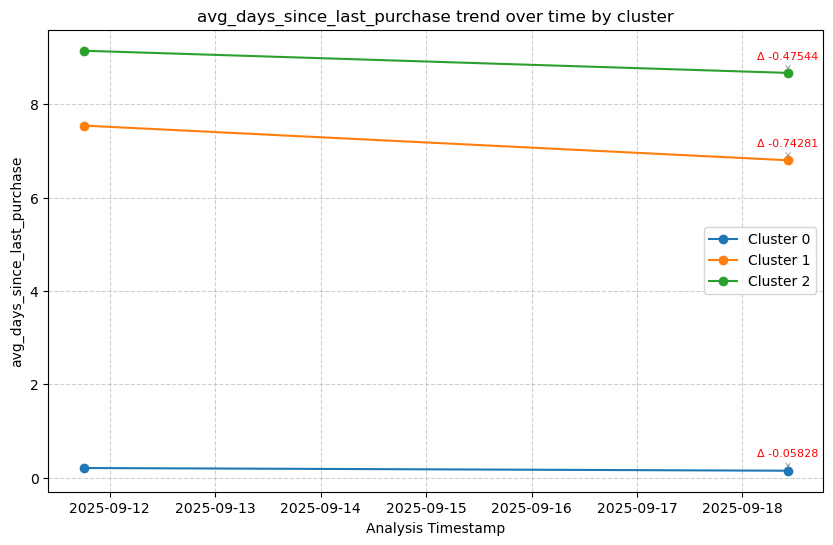

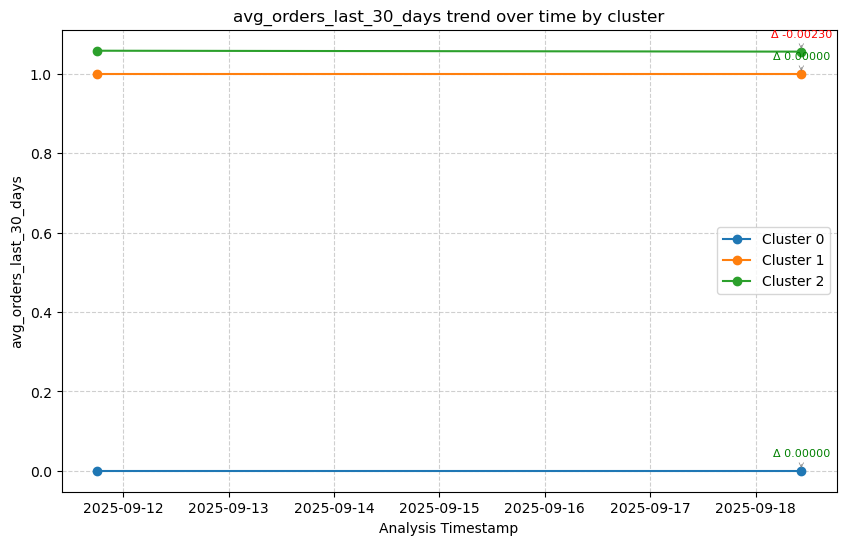

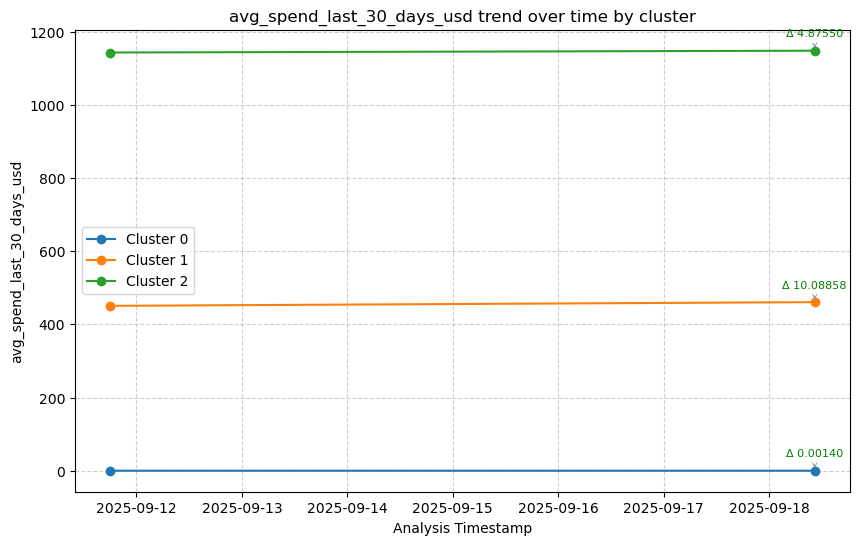

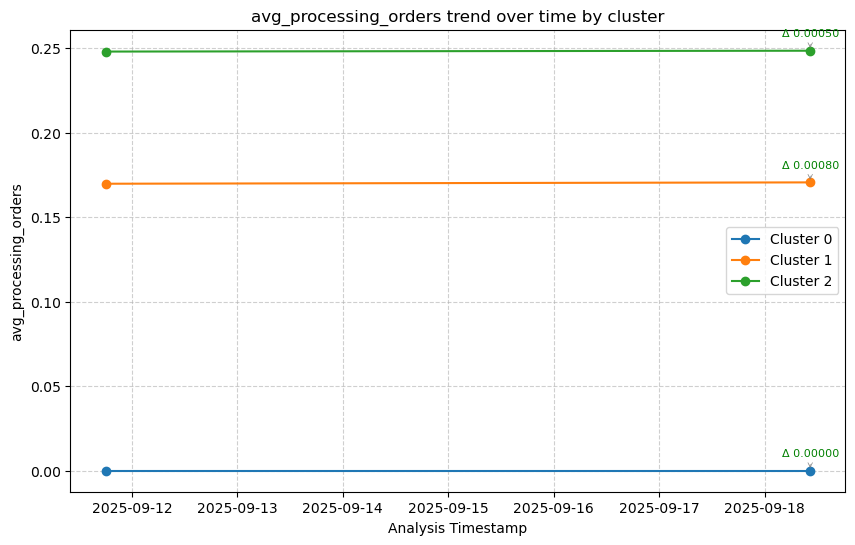

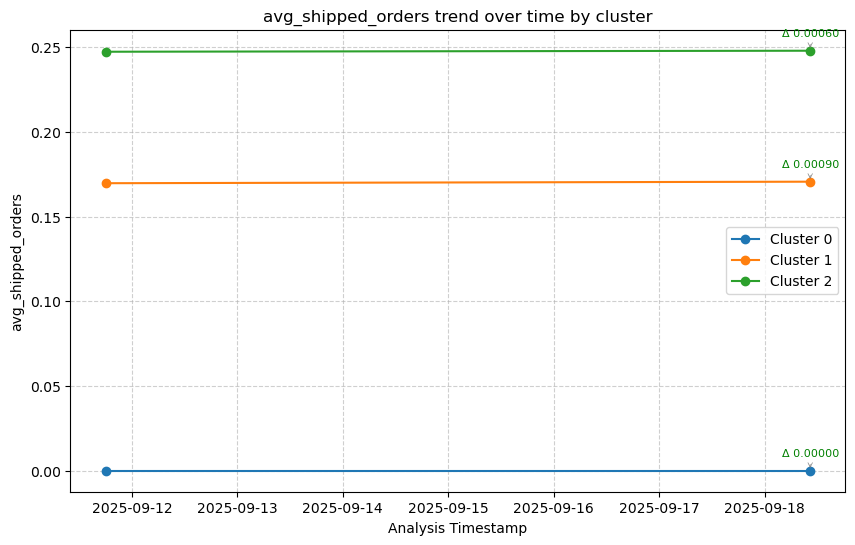

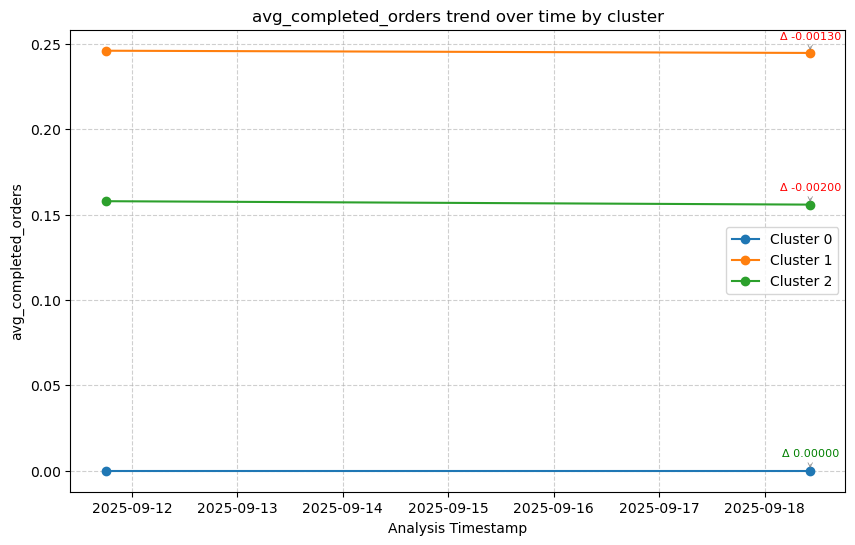

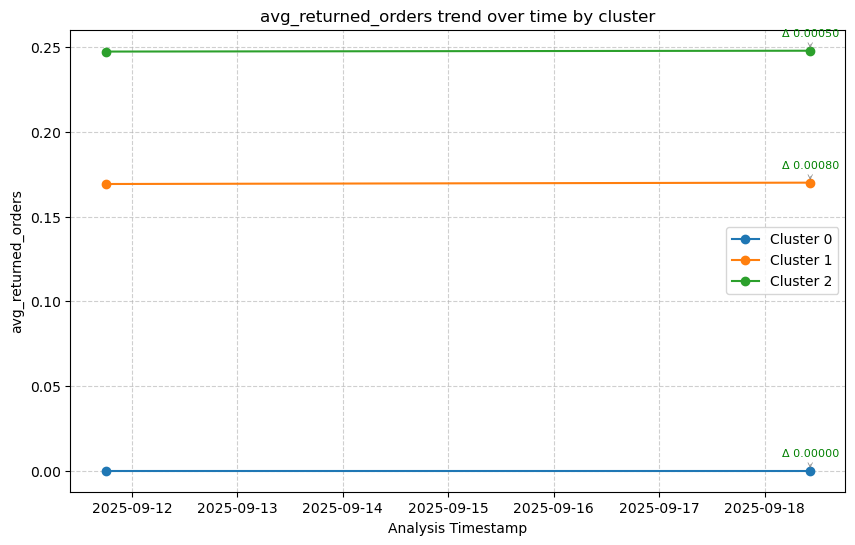

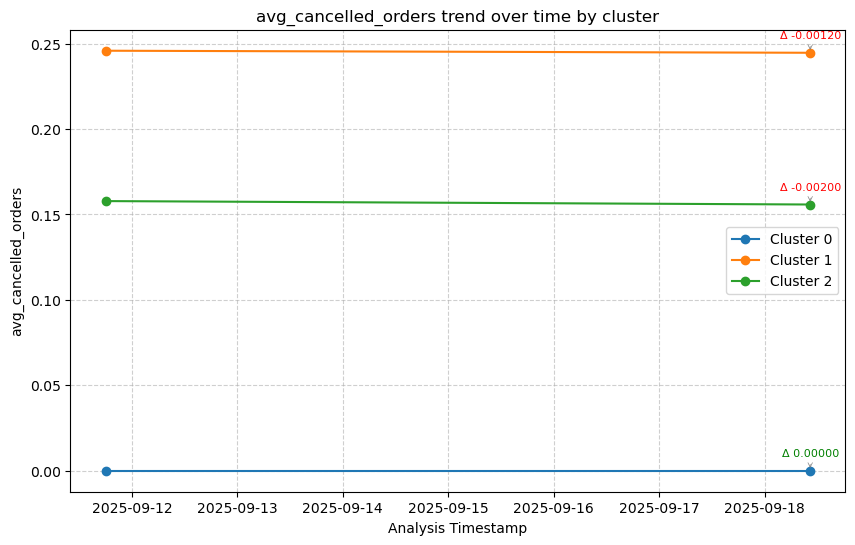

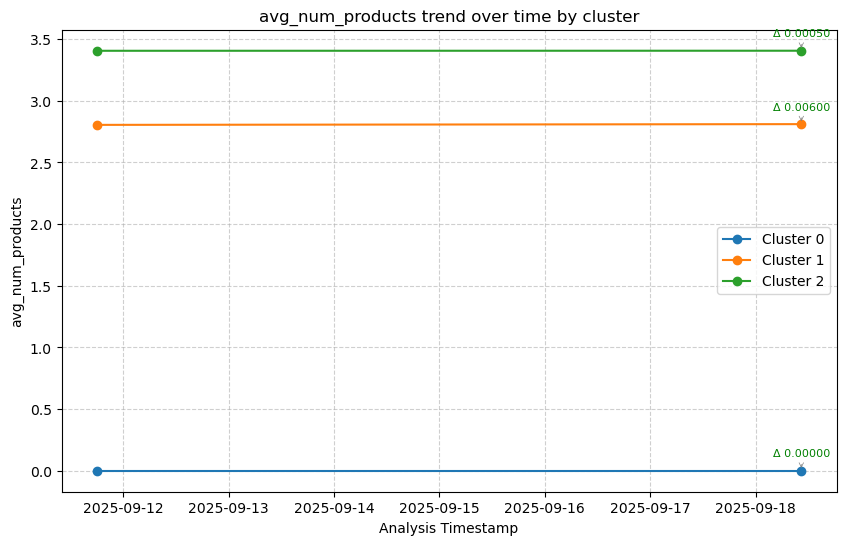

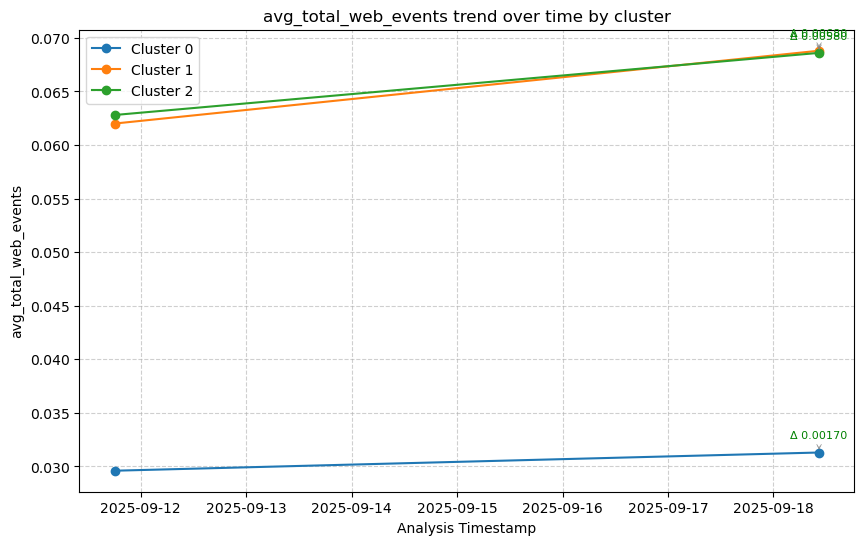

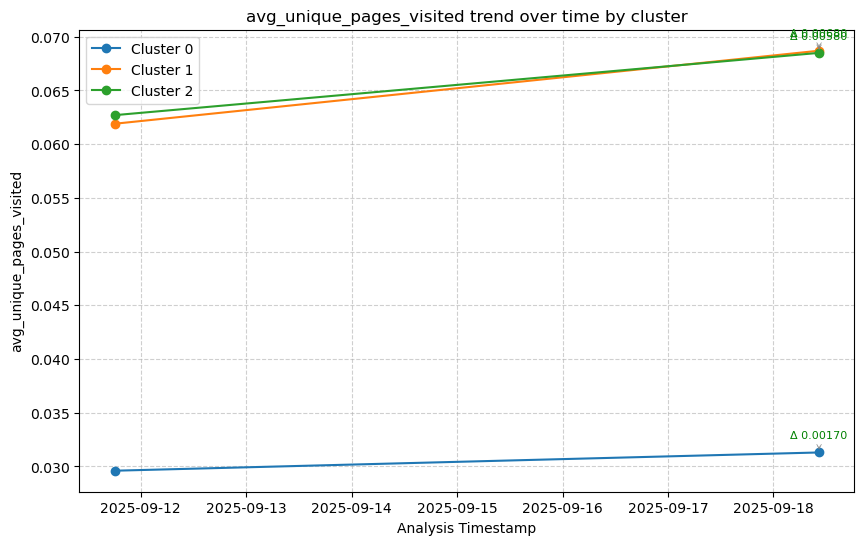

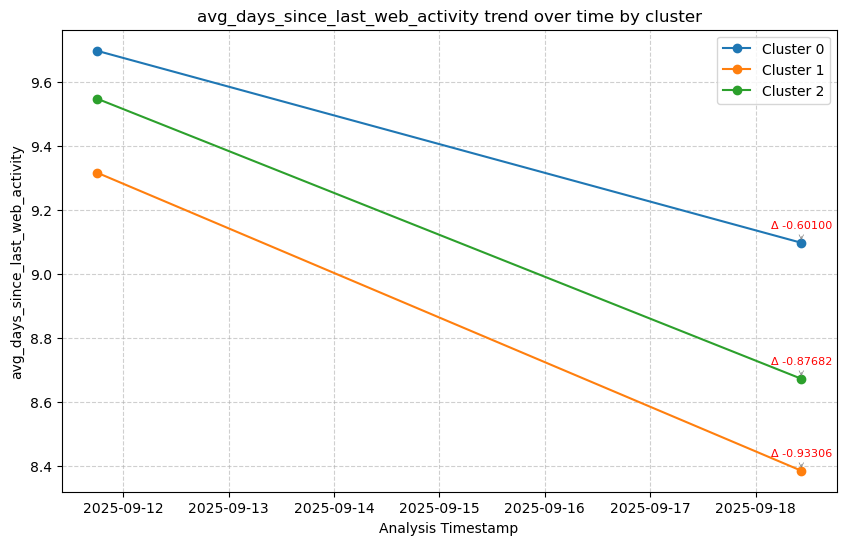

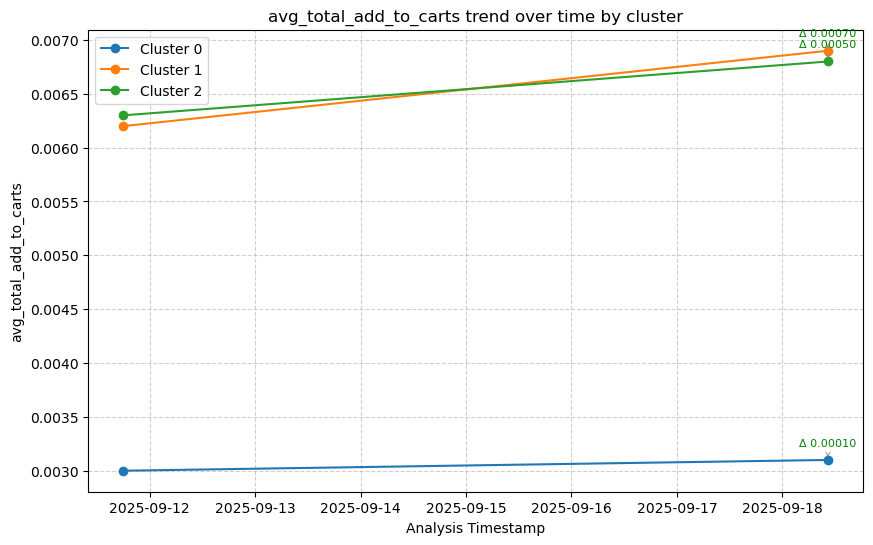

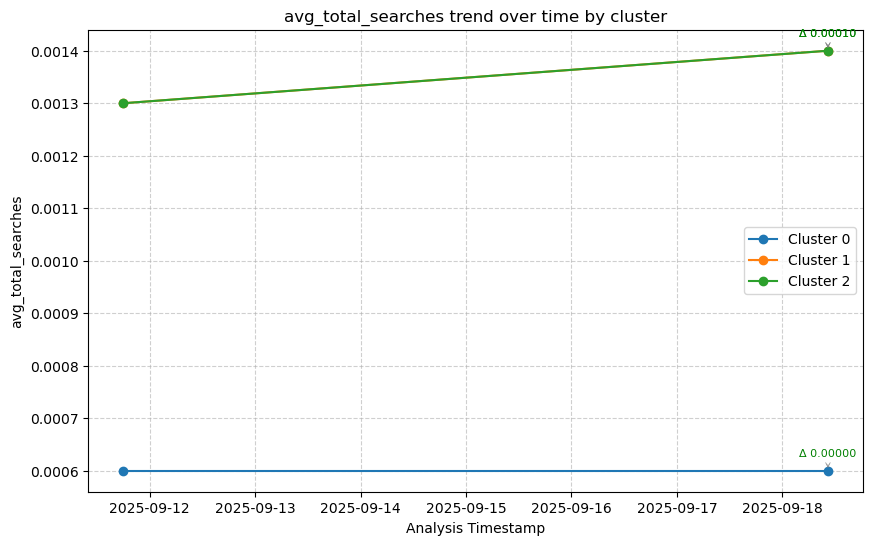

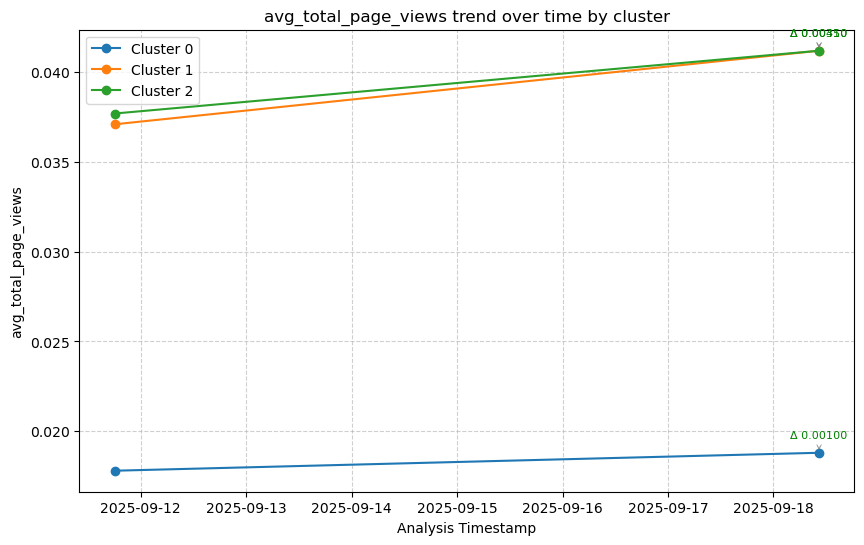

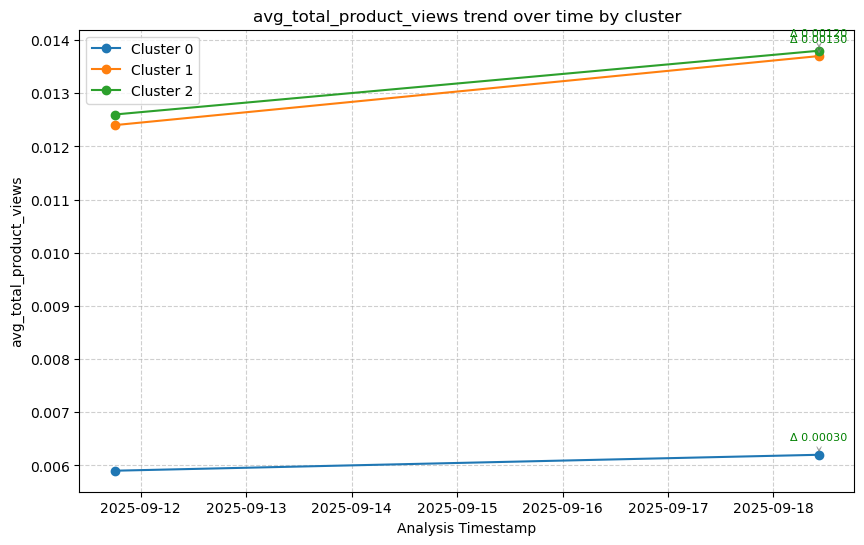

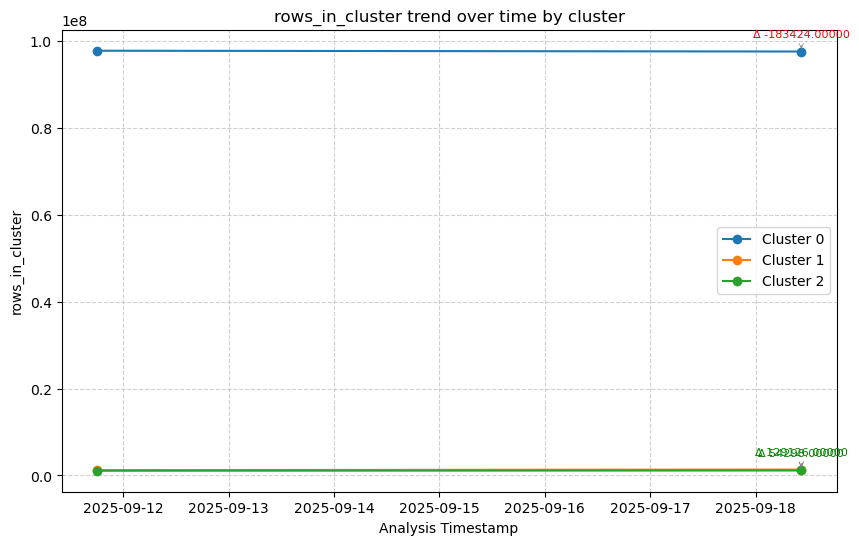

In [7]:
# ------------------------------
# 1. Calculate diffs between each consecutive timestamp
# ------------------------------
def calculate_all_diffs(df, metrics):
    diffs = []
    for cluster_id in df['cluster'].unique():
        cluster_df = df[df['cluster'] == cluster_id].sort_values('analysis_timestamp')
        for i in range(1, len(cluster_df)):
            prev = cluster_df.iloc[i-1]
            curr = cluster_df.iloc[i]
            diff = {metric: curr[metric] - prev[metric] for metric in metrics}
            diff['cluster'] = cluster_id
            diff['analysis_timestamp'] = curr['analysis_timestamp']  # timestamp where change happened
            diffs.append(diff)
    return pd.DataFrame(diffs)

metrics = [col for col in df.columns if col not in ['cluster', 'analysis_timestamp']]
diff_df = calculate_all_diffs(df, metrics)

# ------------------------------
# 2. Plot line charts with diffs (Matplotlib)
# ------------------------------
for metric in metrics:
    plt.figure(figsize=(10, 6))

    # Plot each cluster’s line
    for cluster_id in df['cluster'].unique():
        cluster_df = df[df['cluster'] == cluster_id].sort_values('analysis_timestamp')
        plt.plot(
            cluster_df['analysis_timestamp'],
            cluster_df[metric],
            marker='o',
            label=f"Cluster {cluster_id}"
        )

    # Add annotations for diffs
    for _, row in diff_df.iterrows():
        cluster_id = row['cluster']
        diff_val = row[metric]
        ts = row['analysis_timestamp']
        val = df[(df['cluster'] == cluster_id) & (df['analysis_timestamp'] == ts)][metric].values[0]

        plt.annotate(
            f"Δ {diff_val:.5f}",
            (ts, val),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
            color="red" if diff_val < 0 else "green",
            fontsize=8,
            arrowprops=dict(arrowstyle="->", color="gray", lw=0.5)
        )

    plt.title(f"{metric} trend over time by cluster")
    plt.xlabel("Analysis Timestamp")
    plt.ylabel(metric)
    plt.legend()
    plt.autoscale()

    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

    plt.close()


In [9]:
diff_df

,avg_days_since_registration,avg_total_orders,avg_total_spend_usd,avg_avg_order_value_usd,avg_days_since_last_purchase,avg_orders_last_30_days,avg_spend_last_30_days_usd,avg_processing_orders,avg_shipped_orders,avg_completed_orders,...,avg_total_web_events,avg_unique_pages_visited,avg_days_since_last_web_activity,avg_total_add_to_carts,avg_total_searches,avg_total_page_views,avg_total_product_views,rows_in_cluster,cluster,analysis_timestamp
0,0.025329,0.0000,0.001396,0.001396,-0.058276,0.0000,0.001396,0.0000,0.0000,0.0000,...,0.0017,0.0017,-0.601000,0.0001,0.0000,0.0010,0.0003,-183424,0,2025-09-18 10:22:44
1,1.332733,0.0000,10.088581,10.093272,-0.742813,0.0000,10.088581,0.0008,0.0009,-0.0013,...,0.0068,0.0068,-0.933055,0.0007,0.0001,0.0041,0.0013,129126,1,2025-09-18 10:22:44
2,0.735207,-0.0023,4.875497,6.651765,-0.475443,-0.0023,4.875497,0.0005,0.0006,-0.0020,...,0.0058,0.0058,-0.876819,0.0005,0.0001,0.0035,0.0012,54298,2,2025-09-18 10:22:44


In [8]:
# generate cluster insights for all clusters
def generate_cluster_insights(diff_df):
    insights = []
    
    for _, row in diff_df.iterrows():
        cluster_id = row["cluster"]

        # Population change
        pop_change = row["rows_in_cluster"]
        if pop_change > 0:
            pop_text = f"Cluster {cluster_id} grew by {pop_change:,.0f} members."
        elif pop_change < 0:
            pop_text = f"Cluster {cluster_id} shrank by {abs(pop_change):,.0f} members."
        else:
            pop_text = f"Cluster {cluster_id} population remained stable."
        
        # Spend changes
        spend_change = row["avg_total_spend_usd"]
        order_value_change = row["avg_avg_order_value_usd"]
        if spend_change > 0:
            spend_text = f"Average spend increased by ${spend_change:.5f} (AOV change: ${order_value_change:.5f})."
        elif spend_change < 0:
            spend_text = f"Average spend decreased by ${abs(spend_change):.5f} (AOV change: ${order_value_change:.5f})."
        else:
            spend_text = "Average spend remained unchanged."

        # Recency
        recency_change = row["avg_days_since_last_purchase"]
        if recency_change < 0:
            recency_text = f"Customers purchased more recently ({recency_change:.5f} days sooner)."
        elif recency_change > 0:
            recency_text = f"Customers purchased less recently ({recency_change:.5f} days later)."
        else:
            recency_text = "Purchase recency unchanged."

        # Web activity
        web_change = row["avg_days_since_last_web_activity"]
        if web_change < 0:
            web_text = f"Web activity improved ({web_change:.5f} days sooner)."
        elif web_change > 0:
            web_text = f"Web activity declined ({web_change:.5f} days later)."
        else:
            web_text = "Web activity unchanged."

        # Combine
        insight = f"""
        📊 **Cluster {cluster_id} Insights**  
        - {pop_text}  
        - {spend_text}  
        - {recency_text}  
        - {web_text}  
        """
        insights.append(insight)
    
    return "\n".join(insights)


# Generate insights
print(generate_cluster_insights(diff_df))


        📊 **Cluster 0 Insights**  
        - Cluster 0 shrank by 183,424 members.  
        - Average spend increased by $0.00140 (AOV change: $0.00140).  
        - Customers purchased more recently (-0.05828 days sooner).  
        - Web activity improved (-0.60100 days sooner).  
        

        📊 **Cluster 1 Insights**  
        - Cluster 1 grew by 129,126 members.  
        - Average spend increased by $10.08858 (AOV change: $10.09327).  
        - Customers purchased more recently (-0.74281 days sooner).  
        - Web activity improved (-0.93306 days sooner).  
        

        📊 **Cluster 2 Insights**  
        - Cluster 2 grew by 54,298 members.  
        - Average spend increased by $4.87550 (AOV change: $6.65176).  
        - Customers purchased more recently (-0.47544 days sooner).  
        - Web activity improved (-0.87682 days sooner).  
        
